In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# K-means (k分群算法)
K-means是一种无监督学习算法，给定数据集X，K-means能从中发现数据的规律并对数据分成K个群，群之间特征相似度较高。其算法非常好理解：

1. 随机选出k个点，做为k个group的中心点
2. 对每个数据点选择最近的那个中心点，作为该数据点的group
3. 更新k个group的中心点，更新方式为计算该group所有数据点的平均值，作为新的group中心点
4. 重复2-3步骤，知道收敛

### 优缺点

优点：容易实现  
缺点：容易收敛在局部低点、数据量大时计算量大

In [2]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    dataMat = []                #assume last column is target value
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float,curLine)) #map all elements to float()
        dataMat.append(fltLine)
    return dataMat
def distEclud(vecA, vecB):
    return np.sqrt(np.sum(np.power(vecA - vecB, 2))) #la.norm(vecA-vecB)

def randCent(dataSet, k):
    n = np.shape(dataSet)[1]
    centroids = np.mat(np.zeros((k,n)))#create centroid mat
    for j in range(n):#create random cluster centers, within bounds of each dimension
        minJ = min(dataSet[:,j]) 
        rangeJ = float(np.max(dataSet[:,j]) - minJ)
        centroids[:,j] = np.mat(minJ + rangeJ * np.random.rand(k,1))
    return centroids

myData=loadDataSet('./datasets/testSet.txt')
dataMat=np.mat(myData)
randCent(dataMat,2),distEclud(dataMat[0],dataMat[1])

(matrix([[-3.75679834,  3.04043601],
         [-5.17042988,  0.38445038]]), 5.184632816681332)

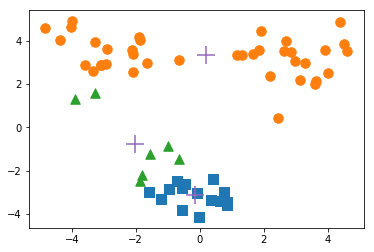

In [53]:
def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
    m = np.shape(dataSet)[0]
    clusterAssment = np.mat(np.zeros((m,2)))#create mat to assign data points 
                                      #to a centroid, also holds SE of each point
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):#for each data point assign it to the closest centroid
            minDist = np.inf; minIndex = -1
            for j in range(k):
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            if clusterAssment[i,0] != minIndex: clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2
#         print(centroids)
        for cent in range(k):#recalculate centroids
            ptsInClust = dataSet[np.nonzero(clusterAssment[:,0].A==cent)[0]]#get all the point in this cluster
            centroids[cent,:] = np.mean(ptsInClust, axis=0) #assign centroid to mean 
    return centroids, clusterAssment

centroids, clustAssign=kMeans(dataMat,3)
fig = plt.figure()
rect=[0.1,0.1,0.8,0.8]
scatterMarkers=['s', 'o','^', '8']
ax1=fig.add_subplot(111)
for i in range(4):
    ptsInCurrCluster = dataMat[np.nonzero(clustAssign[:,0].A==i)[0],:]
    markerStyle = scatterMarkers[i % len(scatterMarkers)]
    ax1.scatter(ptsInCurrCluster[:,0].flatten().A[0], ptsInCurrCluster[:,1].flatten().A[0], marker=markerStyle, s=90)
ax1.scatter(centroids[:,0].flatten().A[0], centroids[:,1].flatten().A[0], marker='+', s=300)
plt.show()

k-means算法容易受到初始值音响，同个数据多跑几次会发现数据簇的中心点变来变去，甚至有时候中心点不准，这就是陷入了局部最优解，故有了优化k-means的算法  
K-means的K个cluster是自定义的，这容易造成k设置不精准，也就是容易陷入局部最优解，接下来，我们透过postprocessing来自动设置k。此算法又称作Bisecting k-means，先从一个cluster开始，若分裂后能让数据点与cluster的中心点距离(SSE)更近，那就分裂，直到分裂到k个簇

In [8]:
def biKmeans(dataSet, k, distMeas=distEclud):
    m = np.shape(dataSet)[0]
    clusterAssment = np.mat(np.zeros((m,2)))
    centroid0 = np.mean(dataSet, axis=0).tolist()[0]
    centList =[centroid0] #create a list with one centroid
    for j in range(m):#calc initial Error
        clusterAssment[j,1] = distMeas(np.mat(centroid0), dataSet[j,:])**2
    while (len(centList) < k):
        lowestSSE = np.inf
        for i in range(len(centList)):
            ptsInCurrCluster = dataSet[np.nonzero(clusterAssment[:,0].A==i)[0],:]#get the data points currently in cluster i
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            sseSplit = np.sum(splitClustAss[:,1])#compare the SSE to the currrent minimum
            sseNotSplit = np.sum(clusterAssment[np.nonzero(clusterAssment[:,0].A!=i)[0],1])
            print("sseSplit, and notSplit: ",sseSplit,sseNotSplit)
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
        bestClustAss[np.nonzero(bestClustAss[:,0].A == 1)[0],0] = len(centList) #change 1 to 3,4, or whatever
        bestClustAss[np.nonzero(bestClustAss[:,0].A == 0)[0],0] = bestCentToSplit
        print('the bestCentToSplit is: ',bestCentToSplit)
        print('the len of bestClustAss is: ', len(bestClustAss))
        centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0]#replace a centroid with two best centroids 
        centList.append(bestNewCents[1,:].tolist()[0])
        clusterAssment[np.nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:]= bestClustAss#reassign new clusters, and SSE
    return np.mat(centList), clusterAssment,lowestSSE

myData=loadDataSet('./datasets/testSet2.txt')
dataMat=np.mat(myData)
centroids, clustAssign, SSE=biKmeans(dataMat,4)

[[-4.36000541 -2.30879879]
 [-4.59206094 -3.23102839]]
[[-0.15301712  1.40566248]
 [-0.294186   -4.0043085 ]]
[[-0.06738038  3.02244526]
 [-0.36852161 -2.96793856]]
[[-0.00675605  3.22710297]
 [-0.45965615 -2.7782156 ]]
sseSplit, and notSplit:  453.0334895807502 0.0
the bestCentToSplit is:  0
the len of bestClustAss is:  60
[[ 4.54872795  1.59418022]
 [-4.16143264  3.84481052]]
[[ 2.93386365  3.12782785]
 [-2.94737575  3.3263781 ]]
sseSplit, and notSplit:  77.59224931775066 29.15724944412535
[[ 0.18215257 -3.09354757]
 [-0.07712694 -4.00366717]]
[[-0.43400906 -2.60222388]
 [-0.60498967 -3.775502  ]]
[[-0.77411615 -2.33877908]
 [ 0.124341   -3.594312  ]]
[[-0.99714875 -2.30782817]
 [ 0.34658275 -3.48379675]]
[[-1.12616164 -2.30193564]
 [ 0.35496167 -3.36033556]]
sseSplit, and notSplit:  12.753263136887313 423.8762401366249
the bestCentToSplit is:  0
the len of bestClustAss is:  40
[[3.11977953 0.6132234 ]
 [1.41152816 3.95008079]]
[[3.3570382  1.8464974 ]
 [2.79280547 3.554938  ]]
[[3.1

In [9]:
centroids

matrix([[ 2.93386365,  3.12782785],
        [-0.45965615, -2.7782156 ],
        [-4.095738  ,  4.4204886 ],
        [-2.56458833,  2.9616746 ]])

sseSplit, and notSplit:  453.0334895807502 0.0
the bestCentToSplit is:  0
the len of bestClustAss is:  60
sseSplit, and notSplit:  77.59224931775066 29.15724944412535
sseSplit, and notSplit:  12.753263136887313 423.8762401366249
the bestCentToSplit is:  0
the len of bestClustAss is:  40


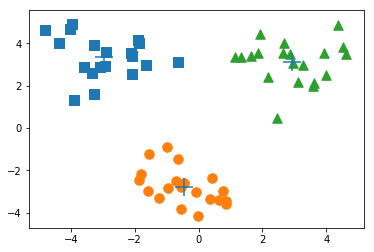

In [61]:
myData=loadDataSet('./datasets/testSet2.txt')
dataMat=np.mat(myData)
centroids, clustAssign, SSE=biKmeans(dataMat,3)
fig = plt.figure()
rect=[0.1,0.1,0.8,0.8]
scatterMarkers=['s', 'o','^', '8']
ax1=fig.add_subplot(111)
for i in range(10):
    ptsInCurrCluster = dataMat[np.nonzero(clustAssign[:,0].A==i)[0],:]
    markerStyle = scatterMarkers[i % len(scatterMarkers)]
    ax1.scatter(ptsInCurrCluster[:,0].flatten().A[0], ptsInCurrCluster[:,1].flatten().A[0], marker=markerStyle, s=90)
ax1.scatter(centroids[:,0].flatten().A[0], centroids[:,1].flatten().A[0], marker='+', s=300)
plt.show()